# SIF DigiLabs Foundational Project

## RiceSense: Rice Leaf Nutrient Deficiency Classification using Convolutional Neural Network
Submitted by: <br>
<b>John Omar D. Esguerra</b> <br>
Philippines

# Image Analysis & Preprocessing

### Importing of Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import cv2
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint


### Load Dataset

In [2]:
healthy_dir ='Rice Dataset/Healthy'
n_def_dir = 'Rice Dataset/N_Deficiency'
p_def_dir = 'Rice Dataset/P_Deficiency'
k_def_dir = 'Rice Dataset/K_Deficiency'
dataset_dir = 'Rice Dataset'

In [3]:
def load_random_imgs_from_folder(folder):
    plt.figure(figsize=(20,20))
    for i in range(5):
        file = random.choice(os.listdir(folder))
        image_path = os.path.join(folder, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1,5,i+1)
        ax.title.set_text(file)
        plt.xlabel(f'Image Shape: {img.shape}')
        plt.imshow(img)

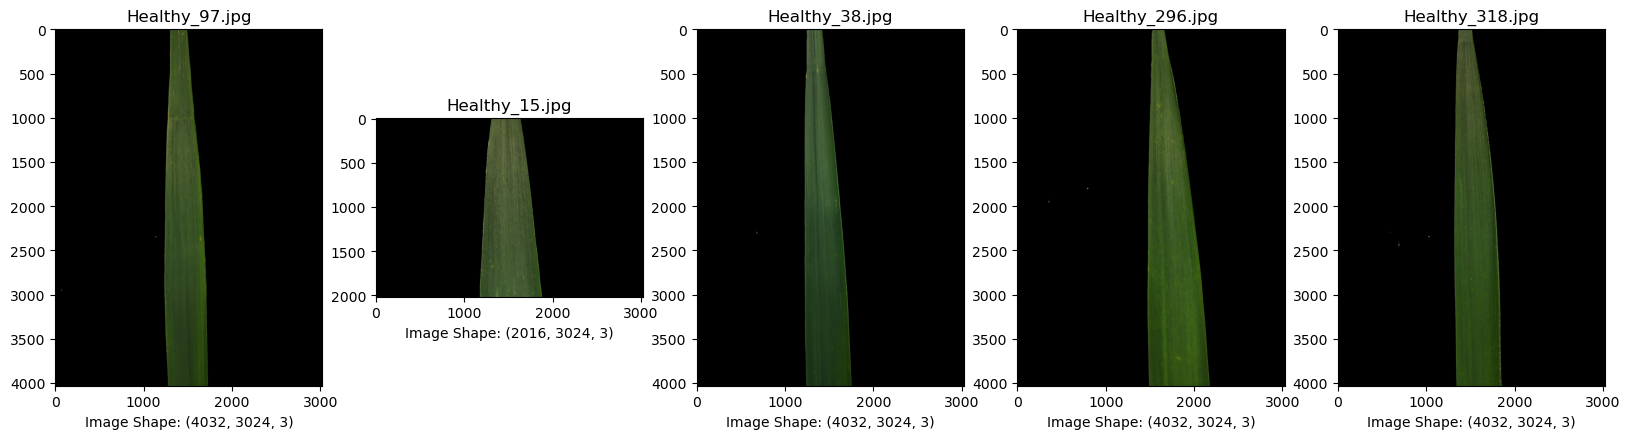

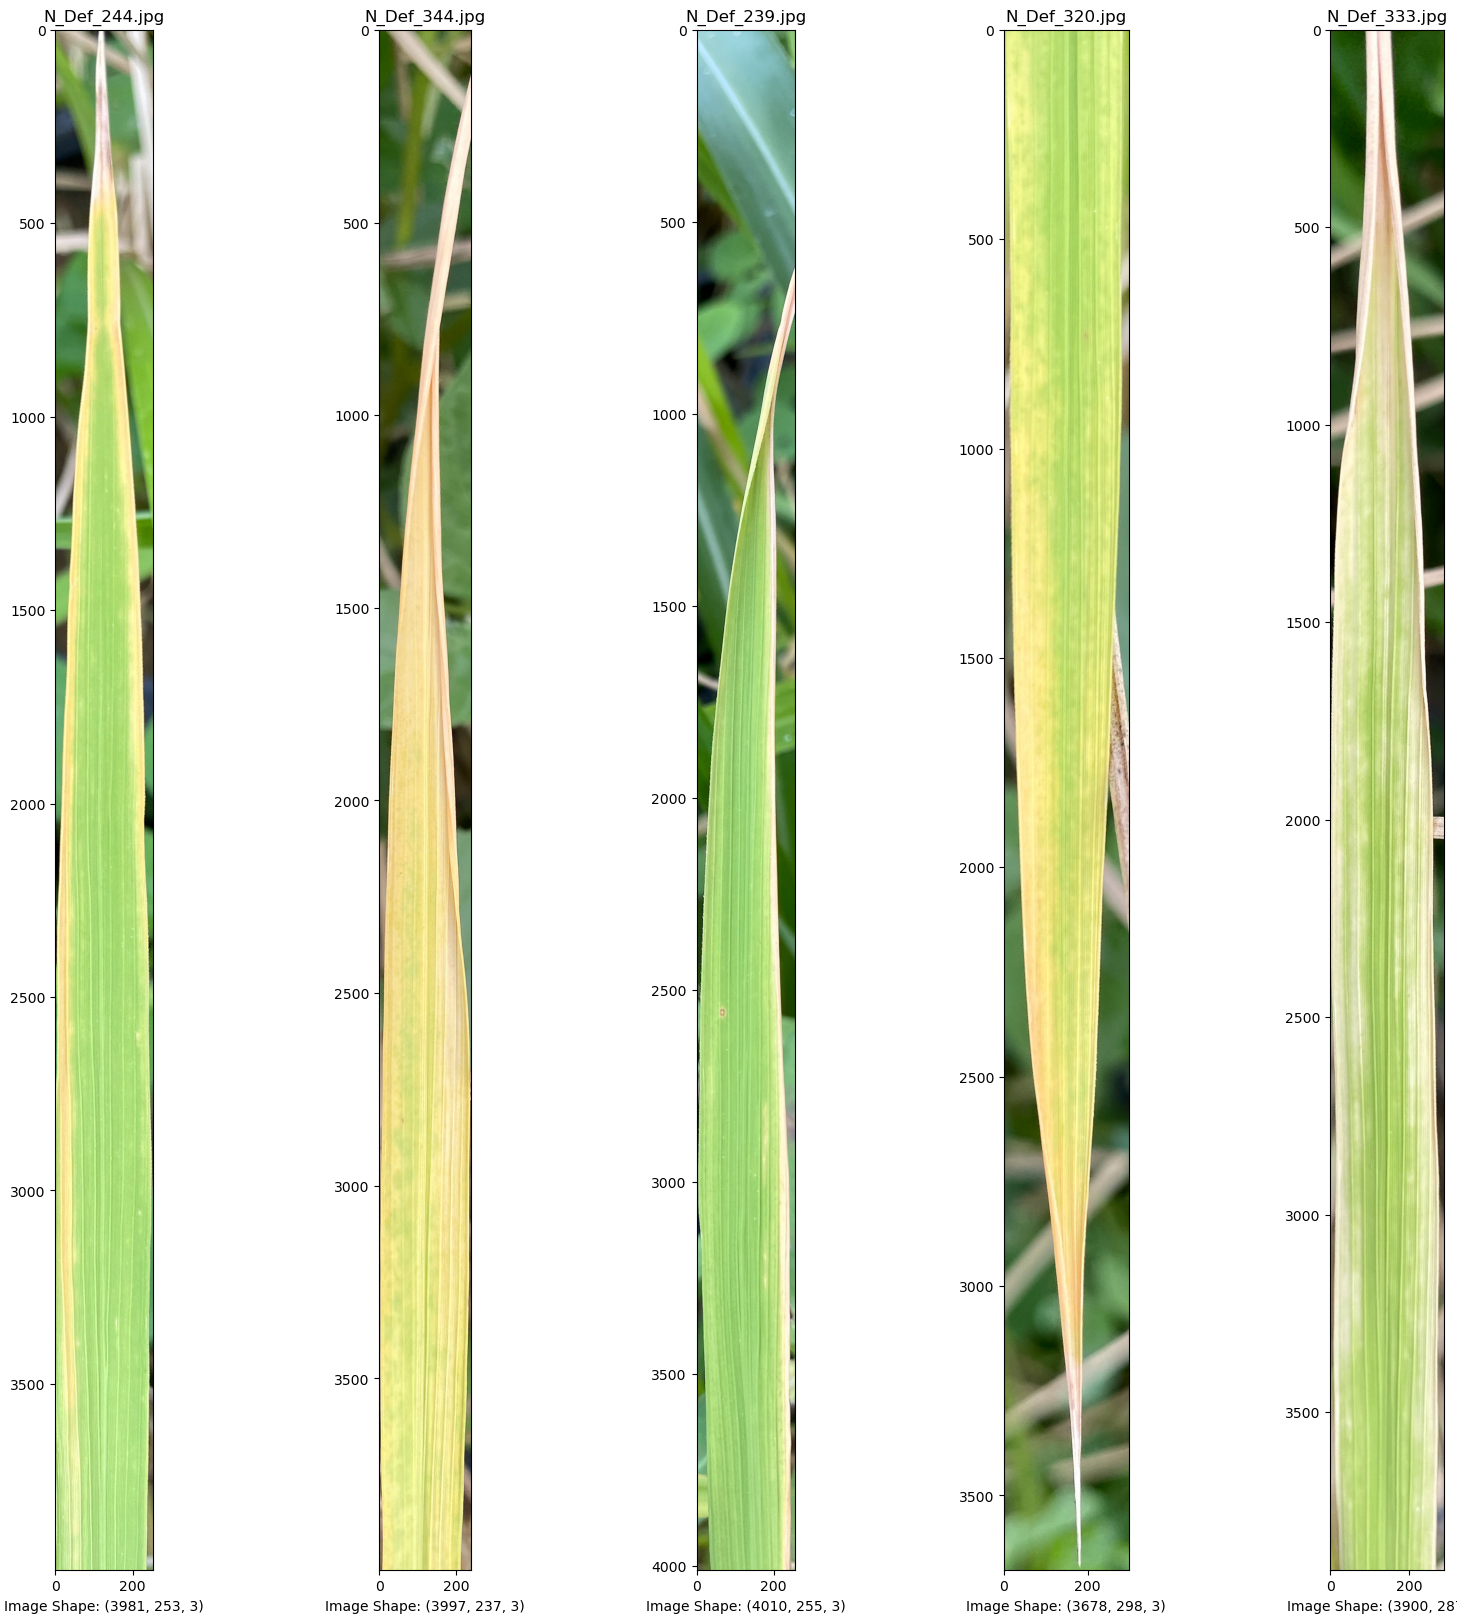

In [4]:
load_random_imgs_from_folder(healthy_dir)
print('\n\n')
load_random_imgs_from_folder(n_def_dir)

### Renaming the file names 

In [5]:
# def rename_imgs(category, path):
#   # print(os.getcwd())
#   os.chdir(path)
#   print(os.getcwd())
#   for index, filename in enumerate(os.listdir(".")):
#     # print(filename, index)
#     os.rename(filename, f'{category}_{index+1}.jpg')
#     # print(filename)

In [6]:
# rename_imgs('Healthy', healthy_dir)
# rename_imgs('N_Def', n_def_dir)
# rename_imgs('P_Def', p_def_dir)
# rename_imgs('K_Def', k_def_dir)

### Resizing image without losing its aspect ratio 

In [7]:
# from PIL import Image
# import PIL
# def resize_imgs(image, fixed_height):
# #     image = Image.open(img_path)
# #     image.load()
#     height_percent = (fixed_height / float(image.size[1]))
#     width_size = int((float(image.size[0]) * float(height_percent)))
#     image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)
#     return np.array(image)
# # image.save('resized_nearest.jpg')

In [8]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

### Create a dataframe

In [9]:
labels=[]
for i in os.listdir(dataset_dir):
    labels+=[i]

print(labels)

['Healthy', 'K_Deficiency', 'N_Deficiency', 'P_Deficiency']


In [10]:
IMG_SIZE = 224

In [11]:
# img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                if img[-3:] != 'txt':
                
#                   image = Image.open(os.path.join(path, img)
                    img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
#                   resized_arr = image_resize(img_arr, height = IMG_SIZE)
#                   resized_arr = resize_imgs(image, IMG_SIZE) # Reshaping images to preferred size
                    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
  

In [12]:
dataset = get_data(dataset_dir)
np.random.shuffle(dataset)

C:\Users\DAREMAPS08\AppData\Local\Temp\ipykernel_36720\1725801830.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [13]:
len(dataset)

1530

In [14]:
train = dataset[:1070]
val = dataset[1070:1300]
test = dataset[1300:]

In [15]:
# train = dataset[:1021]
# val = dataset[1021:1192]
# test = dataset[1192:]

In [16]:
train_df = pd.DataFrame(train,columns=['Feature','Label'])
train_df.head()

,Feature,Label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,"[[[186, 207, 106], [172, 194, 91], [187, 209, ...",3
2,"[[[105, 115, 54], [103, 119, 54], [98, 119, 48...",2
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
4,"[[[66, 104, 1], [58, 97, 1], [56, 94, 1], [58,...",3


In [17]:
l=[]
for i in train_df['Label']:
  l.append(labels[i])

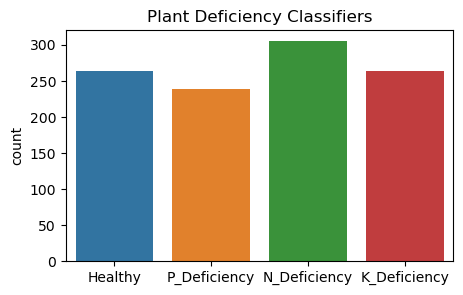

In [18]:
plt.figure(figsize=(5,3))
sns.countplot(x=l);
plt.title('Plant Deficiency Classifiers');

### Splitting the dataset

In [19]:
# X, test_img, Y, test_labels = train_test_split(df['Images'], df['Label'], test_size=0.2, shuffle = True, random_state = 2)

In [20]:
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle = True, random_state = 2)

In [21]:
# # checking the balance of classifiers in the y_train
# print(y_train.value_counts())
# plt.figure(figsize=(7,4))
# sns.countplot(y_train);
# plt.title('Malaria Classifiers');

In [22]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

## Image Preprocessing

### Normalizing the dataset 

In [23]:
np.array(x_train).max()

255

In [24]:
np.array(x_train)

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

Text(0.5, 1.0, 'N_Deficiency')

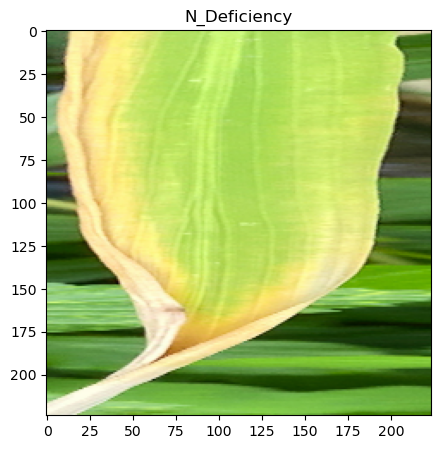

In [25]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [26]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [27]:
x_test = np.array(x_test) / 255.0
y_test = np.array(y_test)

In [28]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1070, 224, 224, 3),
 (1070,),
 (230, 224, 224, 3),
 (230,),
 (230, 224, 224, 3),
 (230,))

In [29]:
type(y_train[0])

numpy.int32

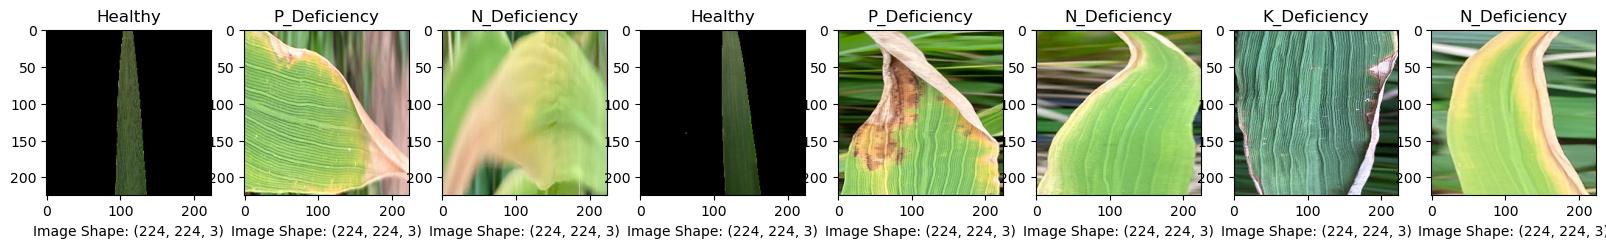

In [30]:
plt.figure(figsize=(20,20))

for i in range(8):
    img = x_train[i]
    ax=plt.subplot(1,8,i+1)
    ax.title.set_text(labels[y_train[i]])
    plt.xlabel(f'Image Shape: {img.shape}')
    plt.imshow(img)

## Image Preprocessing

In [31]:
def plot_before_after(img, filtered_img):
    plt.figure(figsize=(10,10))
    plt.subplot(121),plt.imshow(img),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(filtered_img),plt.title('Filtered')
    plt.xticks([]), plt.yticks([])
    plt.show()

In [32]:
class Filters:
    def __init__(self, x_train):
        self.x_train = x_train
  
    def Gaussian_Blurr(self, kernel):
        self.kernel = kernel
        gauss_blurr = []
        for i in range(len(self.x_train)-1):
            f_img = cv2.GaussianBlur(self.x_train[i], self.kernel,0)
            gauss_blurr.append(f_img)
        return gauss_blurr

    def Median_Blurr(self, K):
        self.K = K
        median_blurr = []
        for i in range(len(self.x_train)-1):
            img = self.x_train[i].astype('float32') / 255.0
            f_img = cv2.medianBlur(img, self.K)
            median_blurr.append(f_img)
        return median_blurr

    def Bilateral_Blurr(self, diameter, sigmaColor, sigmaSpace):
        self.d = diameter
        self.sc = sigmaColor
        self.ss = sigmaSpace
        bilateral_blurr = []
        for i in range(len(self.x_train)-1):
            img = self.x_train[i].astype('float32') / 255.0
            f_img = cv2.bilateralFilter(img, self.d, self.sc, self.ss)
            bilateral_blurr.append(f_img)
        return bilateral_blurr

In [33]:
img_filter = Filters(x_train)

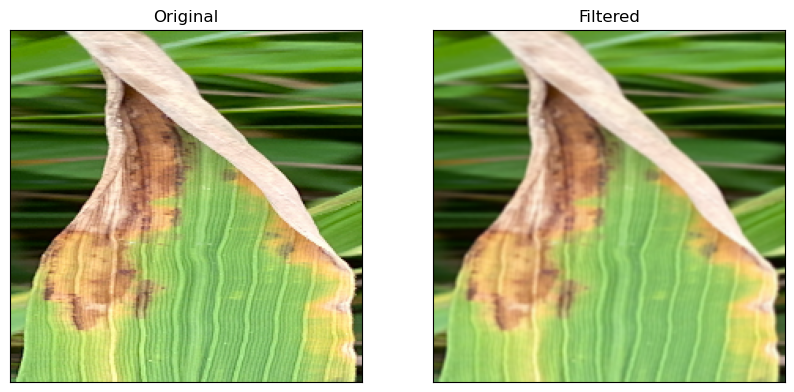

In [34]:
gauss_imgs = img_filter.Gaussian_Blurr((3,3))
plot_before_after(x_train[4], gauss_imgs[4])

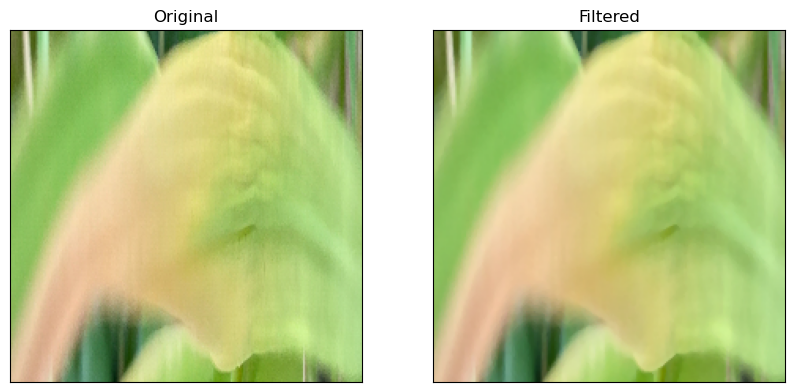

In [35]:
medians = img_filter.Median_Blurr(3)
plot_before_after(x_train[2], medians[2])

### Image Augmentation 

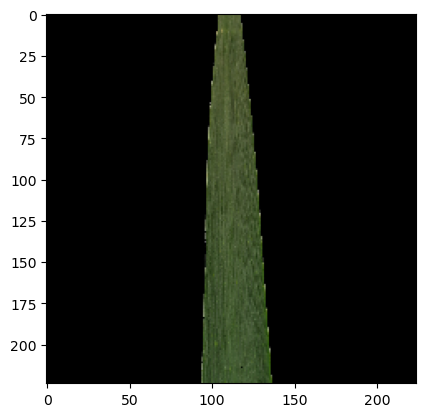

In [36]:
plt.imshow(x_train[0])

In [37]:
x_train[0].shape

(224, 224, 3)

In [38]:
# y_train=y_train.reshape(1070,1)
# y_val=y_val.reshape(230,1)

# # y_train=y_train.reshape(1021,1)
# # y_val=y_val.reshape(171,1)

In [39]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [40]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    featurewise_center=False,  # set input mean to 0 over the dataset 
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

In [41]:
# prepare an iterators to scale images
train_iterator_1 = train_datagen.flow(x_train, y_train, batch_size=64)
val_iterator_1 = val_datagen.flow(x_val, y_val, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator_1), len(val_iterator_1)))

Batches train=17, test=4


In [42]:
# confirm the scaling works
batchX, batchy = train_iterator_1.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 224, 224, 3), min=0.000, max=1.000


## Functions 

In [43]:
def learning_curve(model_fit, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

In [44]:
def confusion_matrix_plot(matrix, model):
    plt.figure(figsize=(12,10))
    cmap = "YlGnBu"
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, fmt='g', ax=ax, cmap=cmap);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);
#     plt.savefig(f'CM_{model}.png', dpi=300)
    plt.show()

In [45]:
def cal_score(model, key):
    
        # evaluate the model
    _, train_acc = model.evaluate(x_train/255.0, y_train, verbose=0)
    _, test_acc = model.evaluate(x_test, y_test, verbose=0)
    _, val_acc = model.evaluate(x_val/255.0, y_val, verbose=0)


    print('Train: %.3f, Test: %.3f, Val: %.3f' % (train_acc, test_acc, val_acc))

    # predict probabilities for test set
    yprobs = model.predict(x_test, verbose=0)
    # predict crisp classes for test set
    yclasses = np.argmax(yprobs,axis=1)


    test_kappa = cohen_kappa_score(y_test, yclasses)
    print('Test Cohens kappa: %f' % test_kappa)
#     val_kappa = cohen_kappa_score(y_val, yclasses)
#     print('Val Cohens kappa: %f' % val_kappa)
    print('\n')
    # confusion matrix
    matrix = confusion_matrix(y_test, yclasses)
    print(matrix)
    print('\n')

    f1 = f1_score(y_test, yclasses, average='weighted')
    print(f'F1 Score: {f1}')
    print('\n')
    
    print(classification_report(y_test, yclasses, target_names=labels))
    
    if key==1:
        confusion_matrix_plot(matrix, model)

## Modelling

### Model 1

In [46]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0),
             ModelCheckpoint(filepath='best2.h5', save_best_only=True)]

In [47]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications.xception import Xception

In [48]:
model3 = Sequential([
    
    # layer 1
    Conv2D(32, kernel_size=(7, 7), activation='relu', padding='same', input_shape=x_train[0].shape),
    Conv2D(32, kernel_size=(7, 7), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # layer 2
    Conv2D(64, kernel_size=(7, 7), activation='relu', padding='same'),
    # Conv2D(64, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # layer 3
    Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same'),
    # Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.2),
    
    Flatten(),
    
    # Fully Connected Layer
    Dense(128, activation='relu'),
    # BatchNormalization(),
    Dropout(0.5),
    
    Dense(4, activation='softmax'),

])

In [49]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.01)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(optimizer = optimizer, 
                   loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                   metrics = ['accuracy'])

In [50]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      4736      
                                                                 
 conv2d_1 (Conv2D)           (None, 218, 218, 32)      50208     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 109, 109, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      100416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

In [51]:
hist = model3.fit(train_iterator_1,epochs=20,verbose=1,validation_data=val_iterator_1, callbacks = callbacks)

Epoch 1/20
17/17 [==============================] - 353s 21s/step - loss: 1.2759 - accuracy: 0.2991 - val_loss: 1.2559 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 382s 23s/step - loss: 1.1369 - accuracy: 0.5131 - val_loss: 1.0698 - val_accuracy: 0.6957
Epoch 3/20
17/17 [==============================] - 406s 24s/step - loss: 0.8258 - accuracy: 0.6692 - val_loss: 0.7085 - val_accuracy: 0.7043
Epoch 4/20
17/17 [==============================] - 358s 21s/step - loss: 0.6527 - accuracy: 0.7028 - val_loss: 0.6338 - val_accuracy: 0.7565
Epoch 5/20
17/17 [==============================] - 350s 21s/step - loss: 0.6324 - accuracy: 0.7187 - val_loss: 0.6196 - val_accuracy: 0.8000
Epoch 6/20
17/17 [==============================] - 360s 21s/step - loss: 0.5864 - accuracy: 0.7495 - val_loss: 0.6014 - val_accuracy: 0.7435
Epoch 7/20
17/17 [==============================] - 322s 19s/step - loss: 0.6176 - accuracy: 0.7215 - val_loss: 0.5969 - val_accuracy: 0.7565
Epoch 

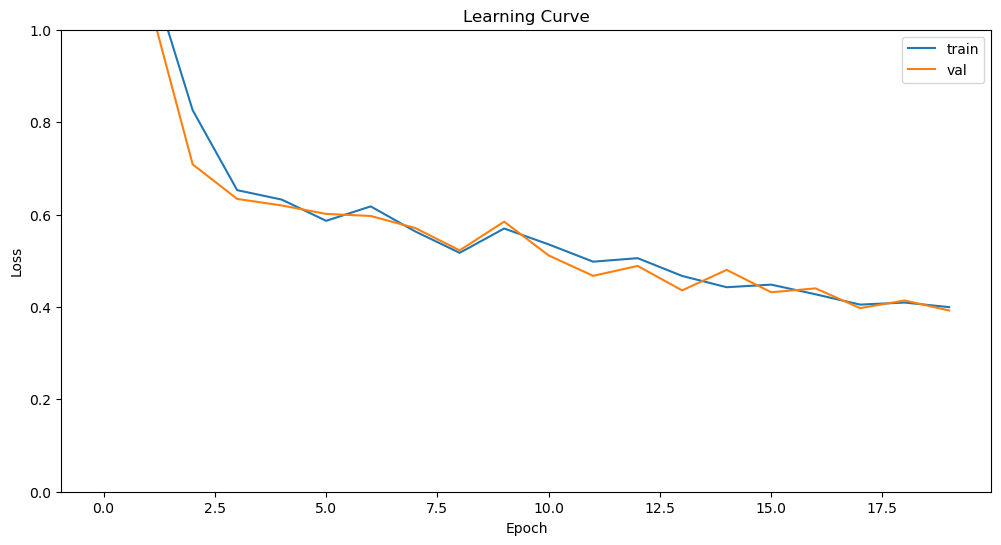

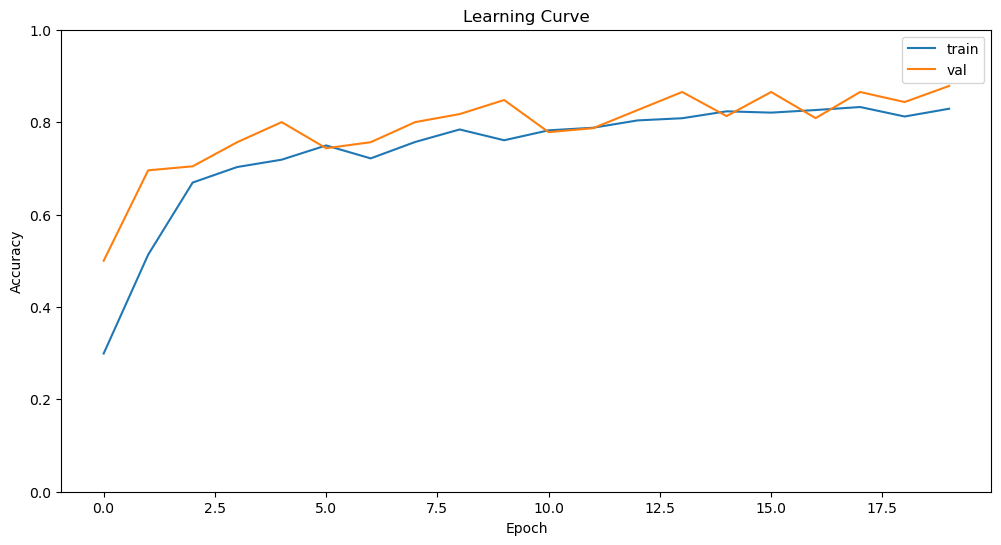

In [52]:
learning_curve(hist,'loss', ylim=(0,1))
learning_curve(hist, 'accuracy', ylim=(0,1))

Train: 0.883, Test: 0.891, Val: 0.878
Test Cohens kappa: 0.853320


[[54  0  0  0]
 [ 0 44  7 11]
 [ 0  2 71  0]
 [ 0  5  0 36]]


F1 Score: 0.8890332478638221


              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        54
K_Deficiency       0.86      0.71      0.78        62
N_Deficiency       0.91      0.97      0.94        73
P_Deficiency       0.77      0.88      0.82        41

    accuracy                           0.89       230
   macro avg       0.88      0.89      0.88       230
weighted avg       0.89      0.89      0.89       230



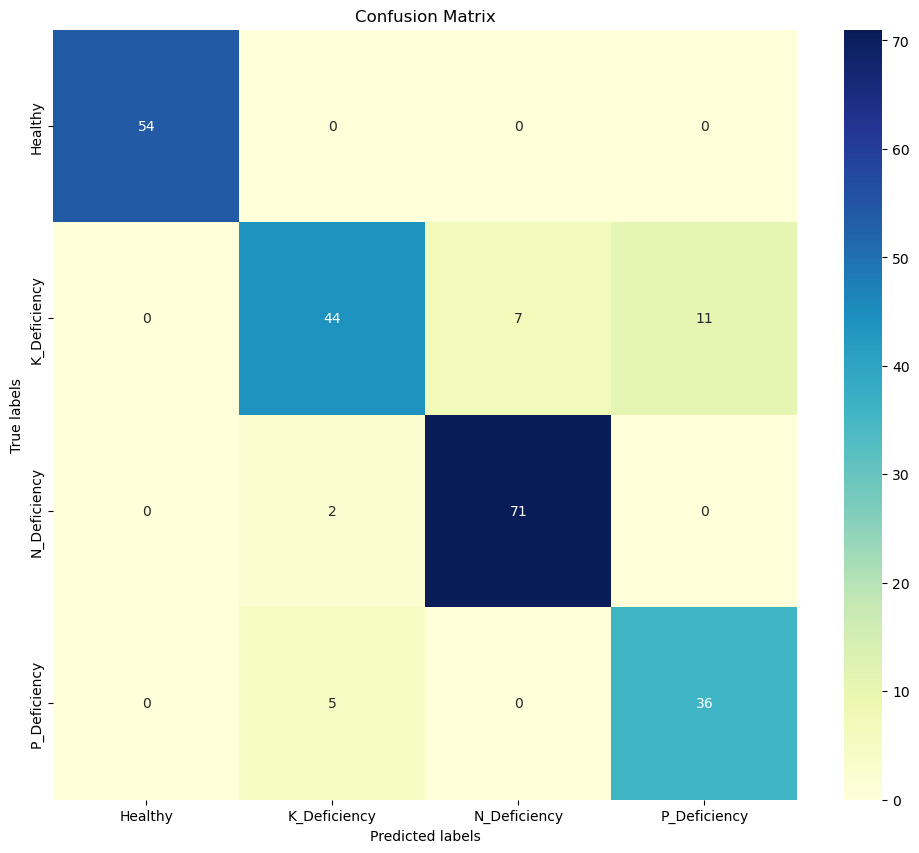

In [53]:
cal_score(model3, 1)

In [54]:
# model3.save('custom-83f1.hdf5')

In [58]:
# best_model = load_model('Rice Dataset/weights.hdf5')
# cal_score(best_model, 1)

In [94]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing import image
from PIL import Image